In [5]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [6]:
#loading dataset
df=pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### DATA CLEANING

In [7]:
#Finding out the Missing Values
missing_values=df.isnull().sum()/len(df)*100
del_cols=[]
for i in range(len(missing_values)):
    if missing_values[i] > 50.0:    # Columns : Alley, PoolQC, Fence, MiscFeature
        print("{} has {:.2f}% missing values".format(df.columns[i],missing_values[i]))
        del_cols.append(df.columns[i])
        

Alley has 93.77% missing values
PoolQC has 99.52% missing values
Fence has 80.75% missing values
MiscFeature has 96.30% missing values


In [8]:
#Dropping columns with really high missing values
df.drop(del_cols, inplace=True,axis=1)

In [9]:
#Finding the columns with NA values and imputing them
pd.set_option('display.max_rows', 10)
NaCount=pd.DataFrame(df.isnull().sum())
NaCols=list(NaCount.index)
count=0
for i in range(len(NaCols)):
    if NaCount[0][i]!=0:
        count+=1
        print(NaCols[i])
if count==0:
    print('No missing values in the dataset')

LotFrontage
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond


In [10]:
def imputer(dataset):
    for col in dataset.columns:
        
        if dataset[col].dtypes=='object':
            dataset[col].fillna(dataset[col].mode()[0],inplace=True)
        elif dataset[col].dtypes=='int64' or dataset[col].dtypes=='float64':
            dataset[col].fillna(dataset[col].mean(),inplace=True)            

    return dataset

df=imputer(df)

In [11]:
#Taking numerical columns and storing to numbercols and category columns to categorycols to identify outliers in the numericols
numbercols=['Id']
categorycols=[]
for col in df.columns:
    if (df[col].dtypes=='int64' or df[col].dtypes=='float64') and col!='Id' :
        #check+=df[col]
        numbercols.append(col)
    else:
        categorycols.append(col)
        
pdf=df[numbercols]
qdf=df[categorycols]

In [12]:
# using IQR for identifying and removing outliers
Q1 = pdf.quantile(0.00)
Q3 = pdf.quantile(0.90)
IQR = Q3 - Q1

newdf = pdf[~((pdf < (Q1 - 1.5 * IQR)) |(pdf > (Q3 + 1.5 * IQR))).any(axis=1)]

In [13]:
#Merging the datasets after removing ouliers
df = pd.merge(left=newdf, right=qdf, left_on='Id', right_on='Id')


Skew is: 1.3372552649125924


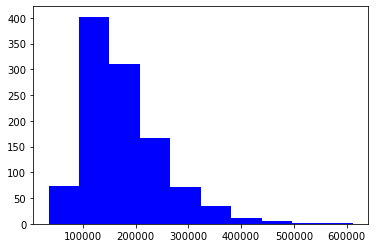

In [14]:
#Using logarithmic function to correct the Skewness of data

print ("Skew is:", df.SalePrice.skew())
plt.hist(df.SalePrice, color='blue')
plt.show()

Skew is: -0.005363788239860514


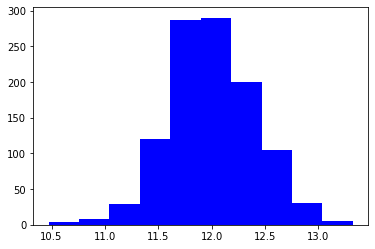

In [15]:
target = np.log(df.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

In [16]:
X=df.drop('SalePrice',axis=1)
Y=target
y=target.values

### Creating new features

#### I have taken first floor area, second floor area and Total basement area to compute the total area of the house

In [17]:
#Feature 1
df['Total_area']=df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']

#### I have taken year sold and month sold and created a new feature that would give the month and year as a single value. 

In [18]:
#Feature 2
MonYear=[]

ylist=list(df['YrSold'])
mlist=list(df['MoSold'])
for i in range(len(ylist)):
    MonYear.append(int(str(ylist[i]) + ((2 - len(str(mlist[i])))*'0') + str(mlist[i])))
    
df['MonYearSold']=MonYear

#### I have taken Garage Area and Garage Year built and created a new feature as both positively affects the price.

In [19]:
#feature 3
GarageAgeArea=[]

ylist=list(df['GarageArea'])
mlist=list(df['GarageYrBlt'].astype(int))
for i in range(len(ylist)):
     GarageAgeArea.append(int(str(ylist[i])+str(mlist[i])))
    
df['GarageAgeArea']=GarageAgeArea  

#### I have taken year built and year remodelled to get a value that has a high value for latest built

In [20]:
#feature 4
df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']

#### I have taken year overall quality of materials and overall condition of the house and created a new feature that would give the overall finish and condition of the house

In [21]:
#feature 5

df['house_Condn']=df['OverallQual']+df['OverallCond']

#### I have taken wooden deck area, porch area, enclosed porch area, three season porch area, screen porch and pool area to create a new feature that would give the outdoor area as a single value. 

In [22]:
#feature 6
df['Outdoor_area']=df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch']+df['PoolArea']

#### I have taken FullBath, HalfBath, BsmtFullBath and BsmtHalfBath to create a new feature that would give the total bathroom area

In [23]:
#feature 7

df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))


#### I have taken OpenPorchSF, 3SsnPorch, EnclosedPorch,ScreenPorch and WoodDeckSF to create a new feature that would give the total Porch area

In [24]:
#feature 8
df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

#### I have taken YearBuilt and YearRemodAdd to create a new feature that would give the years since remodeled 

In [25]:
#feature 9
df['YrsinceRemod']=df['YearBuilt'].astype(int)-df['YearRemodAdd']

#### I have taken YrSold and YearBuilt to create a new feature that would give the HouseAge. 

In [26]:
#Feature 10
df['HouseAge'] = df['YrSold'].astype(int) - df['YearBuilt']

In [27]:
for col in df.columns:
    if (df[col].dtypes == "object"):
        df = pd.concat([df, pd.get_dummies(df[col])], axis = 1)
        df = df.drop([col], axis = 1)

In [28]:
from sklearn.preprocessing import MinMaxScaler
variables = [va for va in df.columns]
x = df.loc[:, variables].values
x = MinMaxScaler().fit_transform(x)
x = pd.DataFrame(x)


In [29]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)

In [30]:
explained_variance = pca.explained_variance_ratio_
np.cumsum(pca.explained_variance_ratio_)[0:5]

array([0.28053996, 0.36004211, 0.40846684, 0.45467325, 0.49444696])

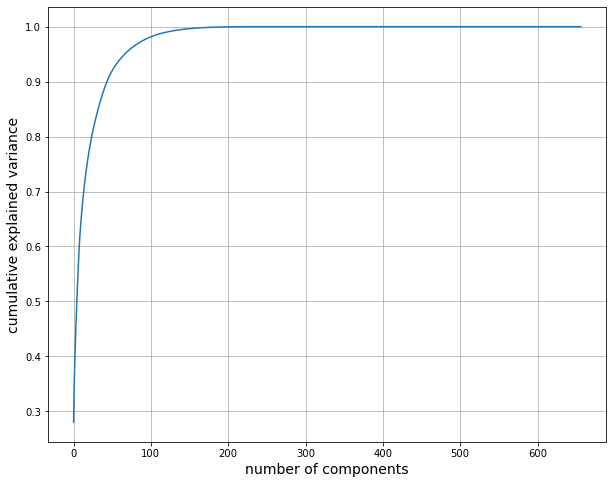

In [31]:
plt.figure(figsize = (10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components', fontsize = 14)
plt.ylabel('cumulative explained variance', fontsize = 14)

plt.grid(True);

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [33]:
pca = PCA(n_components = 10)
X_train1 = pca.fit_transform(x_train) 
X_test = pca.transform(x_test)

In [34]:
imp_features = []
for i in range(10):
   
    imp_features_index = np.abs(pca.components_[i]).argmax()
    imp_features.append(x_train.columns[imp_features_index])
    
imp_features_dict = {'PC{}'.format(i+1): imp_features[i] for i in range(10)}
pd.DataFrame(list(imp_features_dict.items()), columns=['PC', 'Name'])

,PC,Name
0,PC1,241
1,PC2,238
2,PC3,236
3,PC4,233
4,PC5,245
5,PC6,236
6,PC7,242
7,PC8,388
8,PC9,231
9,PC10,388


In [35]:
final_df=x[imp_features]

#### RANDOM FOREST REGRESSOR  AFTER PCA

In [36]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn import metrics

rf_base = RandomForestRegressor(n_estimators=400)
x_train, x_test, y_train, y_test = train_test_split(final_df, y, test_size=0.2, random_state=0)


rf_base.fit(x_train, y_train)
y_pred_rf_base = rf_base.predict(x_test)

rf_base.score(x_test,y_test)

0.6163904611623394

In [37]:
rf_base.score(x_train,y_train)

0.6391623815724663

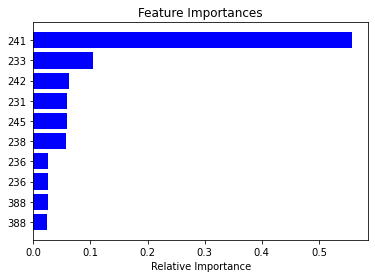

In [38]:
importances = rf_base.feature_importances_
indices = np.argsort(importances)

features = x_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [39]:
import shap
shap_values = shap.TreeExplainer(rf_base).shap_values(x_train)

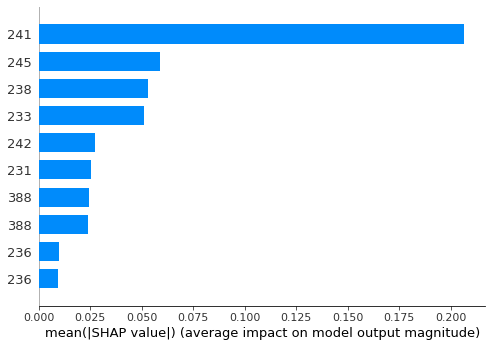

In [40]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

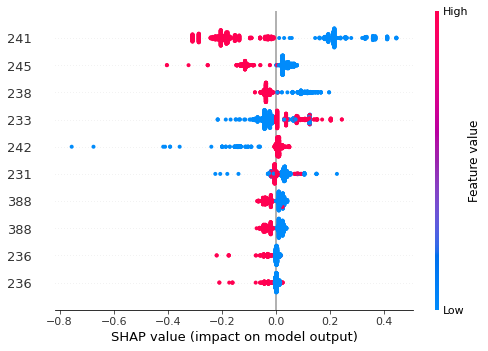

In [41]:
shap.summary_plot(shap_values, x_train)

#### LINEAR REGRESSION AFTER PCA

In [42]:
x_train, x_test, y_train, y_test = train_test_split(final_df, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [43]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = np.exp(df1.head(25))


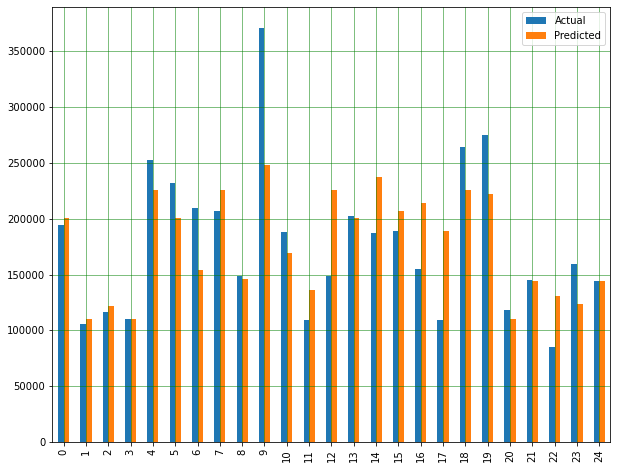

In [44]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [45]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

12.471360896005251
[-0.51323202 -0.16223953 -0.04376132  0.05526147 -0.18085351 -0.04376132
  0.11346135 -0.06045316 -0.14991206 -0.06045316]


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
print("MAE test score:", mean_absolute_error(y_test, y_pred))
print("MSE test score:", mean_squared_error(y_test, y_pred))
print("RMSE test score:", sqrt(mean_squared_error(y_test, y_pred)))

MAE test score: 0.18376037006130527
MSE test score: 0.06441643428565944
RMSE test score: 0.25380392882234787


#### SVM REGRESSION AFTER PCA

In [47]:
from sklearn.svm import SVR

In [48]:
svrs = [SVR(kernel='linear', gamma='scale'), SVR(kernel='poly', gamma='scale'), SVR(kernel='rbf', gamma='scale')]

In [49]:
for model in svrs:
    model.fit(x_train,y_train)

In [50]:
scores=[rg.score(x_test, y_test) for rg in svrs]
scores

[0.5969140478310899, 0.605866438544724, 0.6157180387098584]

### FEATURE IMPORTANCE

Feature: 6, Score: -74813266299.04622
Feature: 7, Score: 88429668728.94450
Feature: 41, Score: -85348491313.85155
Feature: 46, Score: 125004277606.96573
Feature: 159, Score: -123344154424.30464
Feature: 231, Score: -70734082342.13705
Feature: 237, Score: 98921631627.02826
Feature: 271, Score: 83569850084.97780
Feature: 366, Score: -67069363615.72366
Feature: 431, Score: 83569850084.97780
Feature: 487, Score: -83580161521.47469
Feature: 535, Score: -83580161521.47469


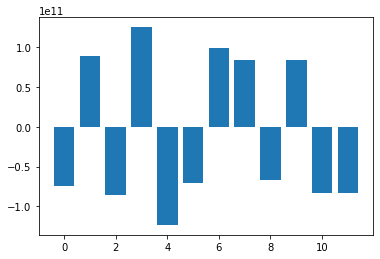

In [51]:
#Feature Importance
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
features=[]
cols=[]
# define the model
model = LinearRegression()
# fit the model
model.fit(x, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
     if v >80550000000.83089 or v<-67019010474:
        print('Feature: %0d, Score: %.5f' % (i,v))
        features.append(v)
        cols.append(i)
        
# plot feature importance
pyplot.bar([x for x in range(len(features))], features)
pyplot.show()

In [52]:
final_df=x[cols]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.2, random_state=0)

### RANDOM FOREST

In [54]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
rf_base = RandomForestRegressor(n_estimators=400)

In [55]:
from sklearn import metrics

rf_base.fit(X_train, y_train)
y_pred_rf_base = rf_base.predict(X_test)

In [56]:
rf_base.score(X_test, y_test)

0.5063499030265115

In [57]:
rf_base.score(X_train, y_train)

0.8365546390750553

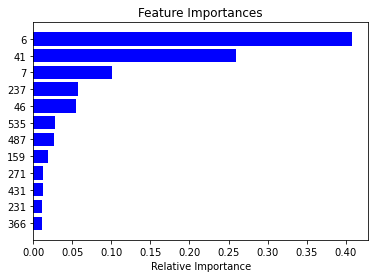

In [58]:
importances = rf_base.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf_base).shap_values(x_train)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")


In [ ]:
shap.summary_plot(shap_values, x_train)

### LINEAR REGRESSION

In [59]:
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [60]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = np.exp(df1.head(25))

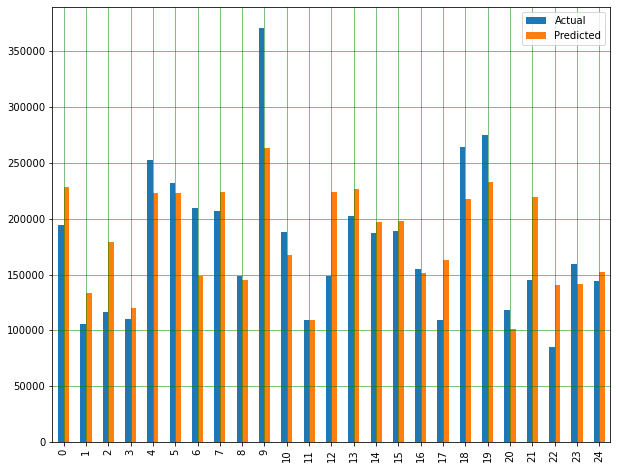

In [61]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [62]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

-3153098760753.9663
[-1.49538363e+13  1.90833794e+12  7.50153495e+12  8.69706222e+12
 -2.24541660e-02 -2.11608607e+11  4.49484068e-02  1.64857042e+11
  2.11608607e+11 -1.64857042e+11  3.04741561e+11 -3.04741561e+11]


In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
print("MAE test score:", mean_absolute_error(y_test, y_pred))
print("MSE test score:", mean_squared_error(y_test, y_pred))
print("RMSE test score:", sqrt(mean_squared_error(y_test, y_pred)))

MAE test score: 0.20117817005447555
MSE test score: 0.0695748832726765
RMSE test score: 0.2637705125154753


#### SVM REGRESSION AFTER FEATURE IMPORTANCE

In [64]:
from sklearn.svm import SVR
svrs = [SVR(kernel='linear', gamma='scale'), SVR(kernel='poly', gamma='scale'), SVR(kernel='rbf', gamma='scale')]

In [65]:
for model in svrs:
    model.fit(X_train,y_train)

In [66]:
scores=[rg.score(X_test, y_test) for rg in svrs]
scores

[0.56744242683176, 0.5916088905354036, 0.5887225602354493]

__Observations made:__

* Removing outliers and imputing missing values has improved the quality of dataset.
* Adding new features has helped to improve performance compared to previous results.
* Previously models had a tendency to overfit and that has been resolved by using outlier removal, scaling, normalization, better feature selection techniques etc.
* Performace metrics such as RMSE,MSE,rf_base score, rg score showed good improvement compared to previous results.
* Features selected using PCA showed better performace in this instance for all the models used.